# OSKAR Simulation Regridder

Refer to the [reformatting guide](reformatter.pdf) for structured guide on how to reformat and regrid.

Note that each step is done in a seperate nested loop for testing purposes. These nested loops can be conjoined in implementation to a final python script.

## Step 0: Define parameters & Inputs

In [1]:
# Starting imports
import os
import numpy as np
import copy
import astropy.units as u 
import astropy.constants as c 
from astropy.cosmology import FlatLambdaCDM as fmodel, z_at_value as getz
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline as misp
from astropy.coordinates import SkyCoord

print("Initialising ...")

# Constant values
H0 = 100 * u.km / u.s / u.Mpc# Set Hubble Constant to 100 h, with h being dimensionless hubble parameter

# Define input array of dimensions (x, y, t)
d = (100, 100, 100) # Number of voxels in simulation
v = (1, 1, 1) * u.Mpc # Initial voxel dimensions in h^-1 Mpc

# Define additional parameters
z_ref = 7 # Refrence redshift, redshift of greatest cube
phase_ref_point = SkyCoord(ra=0*u.rad, dec=0*u.rad, frame='icrs') # Bottom-left corner of plot
require_regrid = True # If true then always regrid, if false, regrid only when max frequency resolution is met
max_freq_res = 100e6 # Provide value in Hz

# Speed flag indicators
uniform_spaxels = True # If true then each spaxel has the same physical dimensions

print("Creating mock brightness temperatures ...")
# Set values array
values = np.ones(d) * 10 # Create a temperature array #

print("Creating mock voxels ...")
# Set voxels array
voxels = np.full((*d, 3), v.to(u.Mpc))

Initialising ...
Creating mock brightness temperatures ...
Creating mock voxels ...


In [2]:
# Define cosmology
cosmo = fmodel(H0=H0, Om0=0.31, Ob0=0.048) # Flat ΛCDM means Dark Energy density is 0.69

# Redshift to comoving distance
def z_to_Dz(z): return cosmo.comoving_transverse_distance(z)

# Comoving distance to redshift
def Dz_to_z(Dz): return getz(cosmo.comoving_transverse_distance, Dz)

# Redshift to frequency in GHz
def z_to_f(z): return 1.42e9 * u.Hz / (z + 1)

# Calculate refrence comoving dist.
Dz_ref = z_to_Dz(z_ref)
f_ref = z_to_f(z_ref)
Dz_CMB = z_to_Dz(1100)

print("z = 7:    D(z) = " + str(Dz_ref.to(u.Glyr))+";  "+str(Dz_ref))
print("z = 1100: D(z) = " + str(Dz_CMB.to(u.Glyr))+"; "+str(Dz_CMB))

z = 7:    D(z) = 19.47498370027101 Glyr;  5971.057146453971 Mpc
z = 1100: D(z) = 30.830580748906996 Glyr; 9452.699028832849 Mpc


# Step 1: Convert each spaxel's dimensions from comoving coordinates to flat angular distance

In [3]:
for x in range(d[0]):
    for y in range(d[1]):

        Dz = Dz_ref.to_value(u.Mpc)

        for t in range(d[2]):

            # If each spaxel is uniform
            if uniform_spaxels and not (x == 0 and y == 0):
                voxels[x, y, t, 0] = voxels[0, 0, t, 0]
                voxels[x, y, t, 1] = voxels[0, 0, t, 1]
                continue
            
            # Retreive voxel values
            dx = voxels[x, y, t, 0]
            dy = voxels[x, y, t, 1]
            Dz_pix = Dz+voxels[x, y, t, 2]/2 # Alter it by the CENTRAL pixel value

            # Calculate transformed dimensions
            dθ = dx/Dz_pix
            dφ = dy/Dz_pix

            # Load back into array
            voxels[x, y, t, 0] = dθ
            voxels[x, y, t, 1] = dφ

            Dz = Dz + voxels[x, y, t, 2] # Increment the value of Dz by voxel dimension
    
        print("\rSpaxel # (", x, ",", y, ")", end="")

Spaxel # ( 99 , 99 )23 ), 45 )

## Part 2 & 3: Convert from comoving distance to redshift and then to frequency

In [4]:
redshifts = np.zeros(d[2])

for x in range(d[0]):
    for y in range(d[1]):

        Dz = Dz_ref
        z_prev = z_ref

        for t in range(d[2]):

            # If each spaxel has same t-dimension gridding save on calc time
            if uniform_spaxels and not (x == 0 and y == 0):
                voxels[x, y, t, 2] = voxels[0, 0, t, 2]
                continue

            # Retreive voxel values
            dDz = voxels[x, y, t, 2] * u.Mpc

            # Determine corresponding redshifts
            z_bot = z_prev
            z_top = Dz_to_z(Dz+dDz)

            # Convert to frequency
            f_bot = z_to_f(z_bot)
            f_top = z_to_f(z_top)

            # Store altered frequency bandwidth
            voxels[x, y, t, 2] = np.abs((f_bot-f_top).to_value(u.Hz))
            redshifts[t] = np.abs(np.float64(z_bot-z_top))

            Dz = Dz + dDz # Increment the value of Dz by voxel dimension
            z_prev = z_top # Top z in current box = bottom z in next box

        print("\rSpaxel # (", x, ",", y, ")", end="")

Spaxel # ( 99 , 99 )

177.5


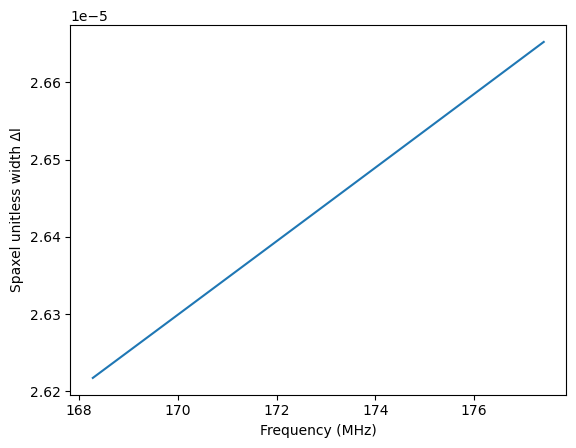

In [5]:
print(f_ref.to_value(u.MHz))
plt.plot(f_ref.to_value(u.MHz)-np.cumsum(voxels[0,0,:,2])/1e6,voxels[0,0,:,0]/(2*np.pi))
plt.xlabel("Frequency (MHz)")
plt.ylabel("Spaxel unitless width Δl")
plt.show()

## Step 4: Convert Brightness Temperature to Janskys per Pixel

In [6]:
for x in range(d[0]):
    for y in range(d[1]):

        fq = f_ref.to_value(u.Hz)

        for t in range(d[2]):
            
            # Retreive values
            Tb = values[x, y, t]
            fxy = fq + voxels[x, y, t, 2]/2
            dθ = voxels[x, y, t, 0]
            dφ = voxels[x, y, t, 1]
            
            # Calculate pixelated luminosity
            Lv = 2 * c.k_B.value * fxy**2 * Tb * (dθ * dφ) / c.c.value ** 2
            Lv = Lv * 1e26 # Converts to Jansky

            # Save into array component
            values[x, y, t] = Lv

            # Increment cumulative frequency
            fq = fq + voxels[x, y, t, 2]

In [7]:
print(np.average(values))

0.0002811210513336732


# Step 5 & 6: Convert flat angular resolution to l, m coords to RA, dec

In [8]:
for x in range(d[0]):
    for y in range(d[1]):
        for t in range(d[2]):

            # Retreive values
            dθ = voxels[x, y, t, 0]
            dφ = voxels[x, y, t, 1]
            
            # Convert to l, m coordinates
            dl = dθ / (2 * np.pi)
            dm = dφ / (2 * np.pi)

            # Convert l, m coordinates to spherical coords
            dRA = np.arcsin(dl)
            dDc = np.arcsin(dm/np.cos(np.arcsin(dm)))

            # Save RA, Dec deltas
            voxels[x, y, t, 0] = dRA
            voxels[x, y, t, 1] = dDc

## Step 7: Regrid frequency bins if needed

In [9]:
# First check if the regridding needs to happen
regrid_flag = False

if not require_regrid:
    for x in range(d[0]):
        for y in range(d[1]):
            for t in range(d[2]):
                if voxels[x, y, t, 2] > max_freq_res:
                    regrid_flag = regrid_flag or True

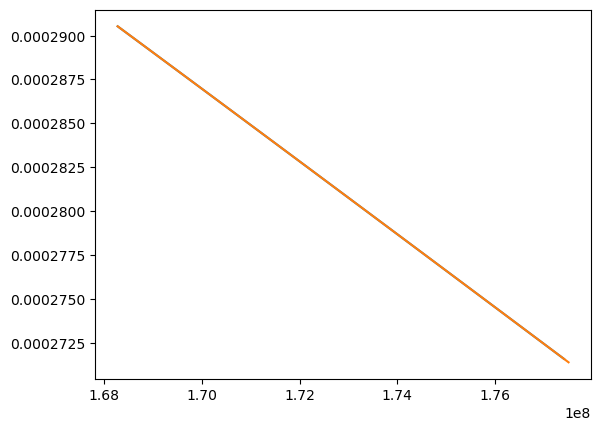

In [10]:
# Test regridding

# Create spline
bspline = misp(np.cumsum(voxels[0, 0, :, 2]), values[0, 0, :])

new_freq = np.linspace(0, np.sum(voxels[0, 0, :, 2]), d[2]+1)
new_lumi = np.clip(bspline(new_freq), 0, None)

plt.plot(f_ref.to_value(u.Hz)-np.cumsum(voxels[0, 0, :, 2]), values[0, 0, :])
plt.plot(f_ref.to_value(u.Hz)-new_freq, new_lumi)
plt.show()

In [11]:
# Next perform the regridding
for x in range(d[0]):
    for y in range(d[1]):
        # Create interpolation B-spline
        bspline = misp(np.cumsum(voxels[x, y, :, 2]), values[x, y, :])

        # Perform regridding
        new_freq = np.linspace(0, np.sum(voxels[x, y, :, 2]), d[2])
        new_lumi = np.clip(bspline(new_freq), 0, None)

        # Create array of uniform bin sizes
        freq_bins = np.ones(d[2]) * np.abs(new_freq[0]-new_freq[1])

        # Save variables
        voxels[x, y, :, 2] = freq_bins
        values[x, y, :] = new_lumi

## Step 8: Save data into OSM file

In [12]:
#str(corner_ref_point.dec.to_value(u.deg))

totalRA = np.mean(np.sum(voxels[:,:,:,0], axis=0))
totalDec = np.mean(np.sum(voxels[:,:,:,1], axis=1))

centering = (lambda x : (x - np.max(x)/2))

print(totalRA)
print(centering(np.cumsum(voxels[:,:,:,0], axis=0)) + np.mean(voxels[:,:,:,0], axis=0)/2)

0.002643366396350752
[[[-0.00129263 -0.00129264 -0.00129264 ... -0.00129327 -0.00129328
   -0.00129328]
  [-0.00129263 -0.00129264 -0.00129264 ... -0.00129327 -0.00129328
   -0.00129328]
  [-0.00129263 -0.00129264 -0.00129264 ... -0.00129327 -0.00129328
   -0.00129328]
  ...
  [-0.00129263 -0.00129264 -0.00129264 ... -0.00129327 -0.00129328
   -0.00129328]
  [-0.00129263 -0.00129264 -0.00129264 ... -0.00129327 -0.00129328
   -0.00129328]
  [-0.00129263 -0.00129264 -0.00129264 ... -0.00129327 -0.00129328
   -0.00129328]]

 [[-0.00126598 -0.00126599 -0.001266   ... -0.00126704 -0.00126705
   -0.00126706]
  [-0.00126598 -0.00126599 -0.001266   ... -0.00126704 -0.00126705
   -0.00126706]
  [-0.00126598 -0.00126599 -0.001266   ... -0.00126704 -0.00126705
   -0.00126706]
  ...
  [-0.00126598 -0.00126599 -0.001266   ... -0.00126704 -0.00126705
   -0.00126706]
  [-0.00126598 -0.00126599 -0.001266   ... -0.00126704 -0.00126705
   -0.00126706]
  [-0.00126598 -0.00126599 -0.001266   ... -0.001267

In [21]:
# RA, Dec centering function
centering = (lambda x: (x - np.max(x)/2))

# Cumulative sums are more important than voxel bins now, add half the mean to approximate centre
rasum = centering(np.cumsum(voxels[:,:,:,0], axis=0)) + np.mean(voxels[:,:,:,0], axis=0)/2
decsum = centering(np.cumsum(voxels[:,:,:,1], axis=1)) + np.mean(voxels[:,:,:,1], axis=1)/2
freqsum = f_ref.to_value(u.Hz) - np.cumsum(voxels[:,:,:,2], axis=2) - np.mean(voxels[:,:,:,2], axis=2)/2
        
# Use Skycoords to calculate spherical RA, Dec offsets
source_pos = phase_ref_point.spherical_offsets_by(rasum * u.rad, decsum * u.rad)
RAs = source_pos.ra.to_value(u.deg)
Dcs = source_pos.dec.to_value(u.deg)

for t in range(d[2]):
    file_freq = np.format_float_positional(freqsum[0, 0, t] / 1e6, 3, False)
    print("Generating OSM for freq0 =", file_freq, "MHz ( file #", t+1, "of", d[2], ")")

    if True:
       # Write OSM lines
        for x in range(d[0]):
            for y in range(d[1]):
                # Format data
                RAscn = np.char.zfill(np.format_float_positional(RAs[x, y, t], 6, False), 10)
                Decln = np.char.zfill(np.format_float_positional(np.abs(Dcs[x, y, t]), 6, False), 9)
                value = np.format_float_scientific(values[x, y, t], 4, False)
                freq0 = np.format_float_positional(freqsum[x, y, t] / 1e6, 3, False)

                # Add +/- value to Declinations
                if Dcs[x, y, y] >= 0: Decln = "+" + str(Decln)
                else:                 Decln = "-" + str(Decln)

                # Write to OSM
                print(freq0)
    break

Generating OSM for freq0 = 177.360 MHz ( file # 1 of 100 )
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.360
177.3

## Mock values presets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def mock_values(preset, scale = 3, d = (100, 100, 100)):
        """
        Create an array of mock simulation values.

        :param preset: Mock brightness temperature array format. Options are {"flat", "random", "gaussian", "sinusoid"}
        :param scale: Define the Kelvin scale of the array (e.g. default value will create a uniform array of 3 K or a random array of 0 - 3 K).
        :return: Mock brightness temperature values.
        """
        print("Creating mock brightness temperatures ...")

        values = None

        normal = lambda x, mean=0, var=1: np.exp(-(x-mean)**2/(2*var))/np.sqrt(2*np.pi*var)
        sinusoid = lambda x, f=1, ph=0: np.sin(2*np.pi*f*x+ph)

        # Set values array
        if preset == "random":
            values = np.random.rand(*d) * scale
        elif preset == "flat":
            values = np.ones(d) * scale
        elif preset == "gaussian":
            time = np.ones(d[0:2])*d[2]/2
            print(d[0:2])
            #values = normal(np.linspace(np.ones(d[0:2])*-d[2]/2, , num=d[2], endpoint=True, axis=2, dtype=np.int32).astype(np.float64), var=d[2])
        elif preset == "sinusoid":
             values = sinusoid(np.linspace(np.ones(d[0:2])*-d[2]/2, np.ones(d[0:2])*d[2]/2, num=d[2], endpoint=True, axis=2, dtype=np.int32).astype(np.float64), f=5/d[2])

        return values.astype(np.float64)

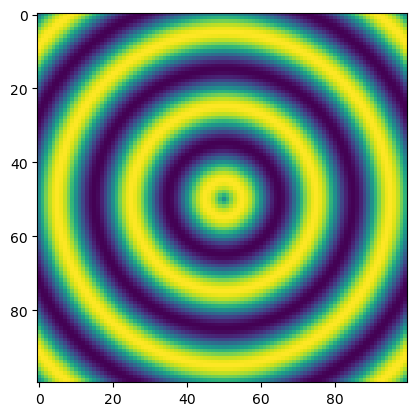

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

normal = lambda x, mean=0, var=1: np.exp(-(x-mean)**2/(2*var))/np.sqrt(2*np.pi*var)
sinusoid = lambda x, f=1, ph=0: np.sin(2*np.pi*f*x+ph)


d = (100, 100, 100)
values = np.zeros(d).astype(np.float64)

for x in range(d[0]):
    for y in range(d[1]):
        for t in range(d[2]):
            values[x, y, t] = np.sqrt((x-d[0]/2)**2 + (y-d[1]/2)**2)

values = sinusoid(values, f=5/d[2])

plt.imshow(values[:,:,50])
plt.show()

In [ ]:
d[0:2]

(100, 100)

# Healpix converter

In [ ]:
import h5py
import numpy as np

In [ ]:
# BrightnessTemp_40a1929eb23a057a0c79883cc341b1f9_r1993.h5
# BrightnessTemp_64b5f6fa04945c6b44a3831c13d78958_r1993.h5

f1 = h5py.File('/home/olivia/.oskar/yuxiang_bts/BrightnessTemp_40a1929eb23a057a0c79883cc341b1f9_r1993.h5', 'r')
f2 = h5py.File('/home/olivia/.oskar/yuxiang_bts/BrightnessTemp_64b5f6fa04945c6b44a3831c13d78958_r1993.h5', 'r')

In [ ]:
for key in list(f1.keys())[1:]:
    print(key)

astro_params
cosmo_params
flag_options
global_params
user_params


In [ ]:
data1 = np.array(f1.get('BrightnessTemp')['brightness_temp'])
data2 = np.array(f2.get('BrightnessTemp')['brightness_temp'])
print(data1.shape, data1.dtype, data2.shape, data2.dtype)

(400, 400, 400) float32 (400, 400, 400) float32


In [ ]:
print(list(f2.get('user_params').attrs))
print(f2.get('global_params').attrs['INITIAL_REDSHIFT'])
print(f2.get('user_params').attrs['BOX_LEN'])
print(f2.get('user_params').attrs['HII_DIM'])

['BOX_LEN', 'DIM', 'FAST_FCOLL_TABLES', 'HII_DIM', 'HMF', 'MINIMIZE_MEMORY', 'NO_RNG', 'N_THREADS', 'PERTURB_ON_HIGH_RES', 'POWER_SPECTRUM', 'USE_2LPT', 'USE_FFTW_WISDOM', 'USE_INTERPOLATION_TABLES', 'USE_RELATIVE_VELOCITIES']
300.0
600
400


In [ ]:
print(list(f2.get('cosmo_params').attrs))
print(f2.get('cosmo_params').attrs['OMb'])
print(f2.get('cosmo_params').attrs['OMm'])
print(f2.get('cosmo_params').attrs['hlittle'])

['OMb', 'OMm', 'POWER_INDEX', 'SIGMA_8', 'hlittle']
0.04897468161869667
0.30964144154550644
0.6766


In [ ]:
print(list(f2.attrs))

['random_seed', 'redshift', 'version']
